In [6]:
import numpy as np
import pandas as pd

In [7]:
filename = 'green_bonds_ispublic.csv'

# Original Tables

In [8]:
original_table1 = pd.DataFrame({
    'Year': list(range(2013, 2019)),
    '# Bonds': [16, 76, 222, 156, 323, 396],
    '$ Amount (billion)': [5.0, 15.4, 28.7, 68.7, 87.8, 95.7]
})
original_table1.set_index('Year', inplace=True)

In [9]:
original_table3_countries = ['China',
                'Netherlands',
                'United States', 
                'France',
                'Germany',
                'Mexico',
                'Sweden',
                'United Kingdom',
                'Luxembourg',
                'Spain',
                'Hong Kong',
                'Japan',
                'Australia',
                'Italy',
                'Norway',
                'India',
                'Brazil',
                'Canada',
                'Denmark',
                'Austria',
                'South Korea',
                'United Arab Emirates',
                'Taiwan',
                'Singapore',
                'Others']

original_table3 = pd.DataFrame({
    'Country': original_table3_countries,
    '# Bonds': [190, 46, 194, 157, 57, 9, 140, 25, 20, 17, 31, 37, 15, 10, 20, 17, 6, 10, 4, 5, 5, 3, 21, 10, 140],
    '$ Amount (billion)': [75.1, 33.2, 31.5, 30.8, 19.4, 12.2, 11.6, 10.8, 8.9, 7.6, 7.4, 6.7, 5.4, 4.6, 4.4, 4.2, 
                          3.4, 3.4, 2.1, 1.7, 1.7, 1.6, 1.6, 1.2, 10.9]
})
original_table3.set_index('Country', inplace=True)

In [54]:
original_table4 = pd.DataFrame({'All': [1189, 775, 526, 400, 253.4, -421, 0.656, -0.475, 7.7, -29.5, 0.753, -0.432, 
                                        0.037, -0.022, 'A-', 
                  'A3', 'A-'],
         'Private': [624, 391, 301, 231, 245.5, -329.5, 0.684, -0.465, 7.4, -5.5, 0.732, -0.443, 0.038, -0.022, 'BBB+',
                    'A3', 'BBB+'],
         'Public': [565, 384, 225, 169, 262, -503.3, 0.625, -0.485, 8.1, -42.3, 0.775, -0.418, 0.036, -0.022, 'A-', 
                    'A2', 'A-']}, index=['# Green bonds', '# Green bond issuer-days',
        '# Green bond issuer-years',
        '# Green bond issuers',
        'Amount (in $M)',
        'Amount (in $M) Standard Deviation',
        'Certified (1/0)',
                                        'Certified (1/0) Standard Deviation',
        'Maturity (years)', 'Maturity (years) Standard Deviation'
        'Fixed-rate bond', 'Fixed-rate bond Standard Deviation',
        'Coupon (for fixed-rate bonds)', 'Coupon (for fixed-rate bonds) Standard Deviation',
        'Credit rating',
        'S&P rating (median)',
        'Moodyʼs rating (median)',
        'Bloombergʼs composite rating (median)']
)
original_table4

,All,Private,Public
# Green bonds,1189,624,565
# Green bond issuer-days,775,391,384
# Green bond issuer-years,526,301,225
# Green bond issuers,400,231,169
Amount (in $M),253.4,245.5,262
Amount (in $M) Standard Deviation,-421,-329.5,-503.3
Certified (1/0),0.656,0.684,0.625
Certified (1/0) Standard Deviation,-0.475,-0.465,-0.485
Maturity (years),7.7,7.4,8.1
Maturity (years) Standard DeviationFixed-rate bond,-29.5,-5.5,-42.3


# Load DB

In [10]:
df = pd.read_csv(filename, parse_dates=['Issue Date'])

# change db
df = df.replace('--', np.nan)   # replace '--' with np.nan to solve errors

# overwrite db and read again to auto-assign correct types and save RAM
df.to_csv(filename, index=False)
df = pd.read_csv(filename, parse_dates=['Issue Date'])

In [11]:
df['Year'] = df['Issue Date'].dt.year
df['$ Amount (billion)'] = df['Amount Issued (USD)'] / 1000000000
df = df[df['Issuer Type']!='Non-US Munis'] # should I EXCLUDE municipalities??

# FILTER TO compare with Flammer's dataset

In [12]:
df = df[df['Year'] > 2012]
df = df[df['Year'] < 2019]
df = df.replace('China (Mainland)', 'China')
# bigger dataset than Flammer's
#df = df[df['Year'] > 2007] # first green bond in 2008
#df = df[df['Year'] < 2020] # Covid might pollute data

In [13]:
df.head()

,Issuer,Ticker,Coupon,Maturity,Issue Date,ISIN,Preferred RIC,Principal Currency,Country of Issue,Issuer Type,...,Amount Issued (USD),Bond Grade,Green Bond,Sector,TRBC Sector,Country of Incorporation,First Announcement Date,IsPublic,Year,$ Amount (billion)
1,Xinjiang Goldwind Science & Technology Co Ltd,XINGO,4.200,NaN,2016-09-01,CND10000C3L5,CN131656002=,Chinese Yuan,China,Corporate,...,7.323646e+07,NaN,Yes,Electronics,Wind Systems & Equipment,China,2016-09-01,True,2016,0.073236
3,CGN Wind Energy Ltd,SASABZ,5.250,NaN,2017-09-14,CND100017CJ8,CN131751002=,Chinese Yuan,China,Corporate,...,1.464729e+08,NaN,Yes,Utility - Other,Electric Utilities (NEC),China,2017-09-08,False,2017,0.146473
6,Engie SA,ENGIE,1.375,NaN,2018-01-16,FR0013310505,FR0013310505=,Euro,France,Corporate,...,1.191001e+09,Investment Grade,Yes,Oil and Gas,Multiline Utilities,France,2018-01-10,True,2018,1.191001
7,Beijing Enterprises Water Group China Investme...,BJEWGC,3.700,NaN,2016-10-31,CND100017C17,CN131651001=,Chinese Yuan,China,Corporate,...,4.101242e+08,NaN,Yes,Service - Other,Water Supply & Irrigation Systems,China,2016-10-26,False,2016,0.410124
8,Iberdrola International BV,IBERD,1.875,NaN,2017-11-22,XS1721244371,ES172124437=,Euro,Eurobond Market,Corporate,...,1.191001e+09,Investment Grade,Yes,Financial - Other,Electric Utilities (NEC),Netherlands,2017-11-15,False,2017,1.191001


In [17]:
df.columns

Index(['Issuer', 'Ticker', 'Coupon', 'Maturity', 'Issue Date', 'ISIN',
       'Preferred RIC', 'Principal Currency', 'Country of Issue',
       'Issuer Type', 'Instrument Type', 'Coupon Type', 'Amount Issued (USD)',
       'Bond Grade', 'Green Bond', 'Sector', 'TRBC Sector',
       'Country of Incorporation', 'First Announcement Date', 'IsPublic',
       'Year', '$ Amount (billion)'],
      dtype='object')

In [18]:
pd.DataFrame(zip(df['TRBC Sector'], df['Sector']))

,0,1
0,Wind Systems & Equipment,Electronics
1,Electric Utilities (NEC),Utility - Other
2,Multiline Utilities,Oil and Gas
3,Water Supply & Irrigation Systems,Service - Other
4,Electric Utilities (NEC),Financial - Other
...,...,...
1168,Investment Holding Companies (NEC),Financial - Other
1169,Photovoltaic Solar Systems & Equipment,Utility - Other
1170,Banks (NEC),Banking
1171,Banks (NEC),Banking


In [19]:
df.describe()

,Coupon,Amount Issued (USD),Year,$ Amount (billion)
count,1163.000000,1.173000e+03,1173.000000,1173.000000
mean,3.254311,2.709371e+08,2016.517477,0.270937
std,2.373543,4.202802e+08,1.383376,0.420280
min,0.000000,1.000000e+04,2013.000000,0.000010
25%,1.080500,1.000000e+07,2015.000000,0.010000
50%,2.980000,8.355935e+07,2017.000000,0.083559
75%,5.010000,4.500000e+08,2018.000000,0.450000
max,11.800000,4.394188e+09,2018.000000,4.394188


# My Table 1. Corporate green bonds over time

In [20]:
table = pd.pivot_table(df,
                       index = ['Year'],
                       values=['$ Amount (billion)'],
                       aggfunc={'Year': 'count', 
                                '$ Amount (billion)': np.sum}) # defaults to 'All'

#format_dict = {'$ Amount (billion':'${0:,.0f}'}
#table.style.format(format_dict)
try:
    table['# Bonds'] = table['Year']
    table = table[['# Bonds', '$ Amount (billion)']] # sort columns, remove duplicate 'Year' column
except KeyError: # if 'Year' has already been removed
    pass

table.to_csv('Table1.csv')
table

,# Bonds,$ Amount (billion)
Year,,
2013,20,4.498003
2014,85,20.051310
2015,225,37.459629
2016,156,59.853437
2017,312,88.106654
2018,375,107.840152


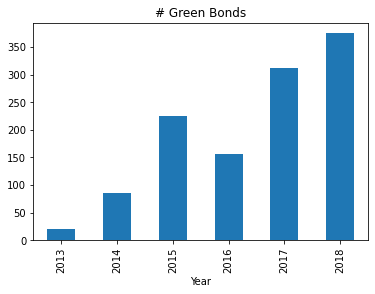

In [21]:
table['# Bonds'].plot.bar(title='# Green Bonds')

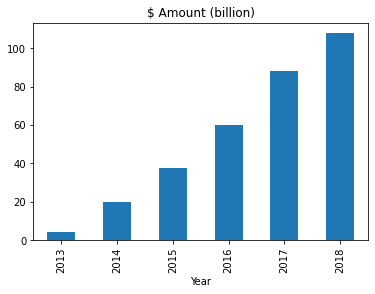

In [22]:
table['$ Amount (billion)'].plot.bar(title='$ Amount (billion)')

# My Table 2. Corporate green bonds by industry

In [43]:
column = 'Sector'
table2 = pd.pivot_table(df,
                       index = [column],
                       values=['$ Amount (billion)'],
                       aggfunc={column: 'count', 
                                '$ Amount (billion)': np.sum})

In [48]:
table2.rename(columns={column: '# Bonds'}, inplace=True) # cannot sort if column.name == index.name
sorter = '# Bonds' #'Count'
table2 = table2[[sorter, '$ Amount (billion)']].sort_values(by=[sorter], ascending=False)

table2.to_excel('MyTable2.xlsx')
table2

,# Bonds,$ Amount (billion)
Sector,,
Utility - Other,315,36.070426
Banking,268,98.896799
Financial - Other,184,55.751735
Agency,149,81.193999
Home Builders,98,7.177195
Service - Other,33,7.346878
Gas Utility - Pipelines,17,0.053633
Real Estate Investment Trust,13,3.963639
Building Products,12,0.732868


In [46]:
def get_industry_cathegory(cat: str):
    categ = cat.replace(' - Other', '')
    if categ in {'Utilities', 
                 'Utility', 'Electronics', 'Oil and Gas', 'Home Builders', 'Metals/Mining', 'Building Products',
                 'Leasing', 'Textiles/Apparel/Shoes',
                'Power generation',
                'Renewable energy',
                'Transportation and logistics',
                'Waste and environment services and equipment',
                'Forest and paper products manufacturing',
                'Automobiles manufacturing',
                'Travel and lodging',
                'Communications equipment',
                'Food and beverage',
                'Containers and packaging',
                'Consumer products',
                'Electrical equipment manufacturing'}:
        return 'Industrials'
    elif categ in {'Banking', 'Real estate', 'Financial'} or 'Banking' in categ or 'Financial' in categ or \
    'Investment' in categ:
        return 'Financials'
    else:
        print(cat)
        return 'Others'
    
# df['my_cat'] = df['Sector'].apply(get_industry_cathegory) # too many missing cat

# My Table 3. Corporate green bonds by country

In [25]:
pivot_column = 'Country of Incorporation' # Country of Issue uses 'Eurobond Mkt' for most EU

table3 = pd.pivot_table(df,
                       index = [pivot_column],
                       values=['$ Amount (billion)'],
                       aggfunc={pivot_column: 'count', 
                                '$ Amount (billion)': np.sum})

table3['# Bonds'] = table3[pivot_column]
table3 = table3[['# Bonds', '$ Amount (billion)']].sort_values('$ Amount (billion)', ascending=False)

table3

,# Bonds,$ Amount (billion)
Country of Incorporation,,
China,118,52.186201
Netherlands,50,37.476577
France,135,37.439487
Germany,50,31.811341
United States,198,29.188592
Sweden,156,16.637134
United Kingdom,25,11.315336
Spain,19,9.128165
Norway,28,8.134983


In [ ]:
# My Table 4. Summary statistics at the green bond level 

In [ ]:
index = ['# Green bond issuer',
        '# Green bond issuer-years',
        '# Green bond issuers',
        'Amount (in $M)',
        'Certified (1/0)',
        'Maturity (years)',
        'Fixed-rate bond',
        'Coupon (for fixed-rate bonds)',
        'Credit rating',
        'S&P rating (median)',
        'Moodyʼs rating (median)',
        'Bloombergʼs composite rating (median)']

values = {'All': [1189, 775, 526, 400, 253.4, -421, 0.656, -0.475, 7.7, -29.5, 0.753, -0.432, 0.037, 0.022, 'A-', 
                  'A3', 'A-'],
         'Private': [624, 391, 301, 231, 245.5, -329.5, 0.684, -0.465, 7.4, -5.5, 0.732, -0.443, 0.038, -0.022, 'BBB+',
                    'A3', 'BBB+'],
         'Public': [565, 384, 225, 169, 262, -503.3, 0.625, -0.485, 8.1, -42.3, 0.775, -0.418, 0.036, -0.022, 'A-', 
                    'A2', 'A-']}

# Compare Tables

In [26]:
with pd.ExcelWriter('Table1.xlsx') as writer:
    table.to_excel(writer, sheet_name='MyTable1')
    original_table1.to_excel(writer, sheet_name='FlammerTable1')
    (table - original_table1).to_excel(writer, sheet_name='Differences')

In [27]:
table2.to_excel('Table2.xlsx')

In [29]:
# get sum of rows not in original_table_3
others_bonds, others_amount = table3[~table3.index.isin(original_table3.index)].sum()

# table3 with same rows of original_table3
comparable_table3 = table3[table3.index.isin(original_table3.index)].append(pd.DataFrame({
    '# Bonds': others_bonds, '$ Amount (billion)': others_amount},
    index=['Others']))

with pd.ExcelWriter('Table3.xlsx') as writer:
    table3.to_excel(writer, sheet_name='MyTable3')
    comparable_table3.to_excel(writer, sheet_name='MyTable3SameIndex')
    original_table3.to_excel(writer, sheet_name='FlammerTable3')
    (comparable_table3 - original_table3).reindex(original_table3.index).to_excel(writer, sheet_name='Differences')